In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')



Mounted at /content/gdrive


In [ ]:
#!unzip '/content/drive/MyDrive/Colab Notebooks/2022.9.10/archive.zip' -d '/content/drive/MyDrive/Colab Notebooks/2022.9.10'
print("============Visulize the GPU information================")
# Visulize the GPU information
!/opt/bin/nvidia-smi
print("==============Visulize the TensorFlow version==============")
# Visulize the TensorFlow version
import tensorflow as tf
print(tf.__version__)
print("============Check the disk capacity of the Virtual Machine================")
# Check the disk capacity of the Virtual Machine
!df -lh
print("============Visulize the CPU information================")
# Visulize the CPU information
!cat /proc/cpuinfo | grep model\ name
print("=============Visulize the Memory Capacity===============")
# Visulize the Memory Capacity
!cat /proc/meminfo | grep MemTotal

============Visulize the GPU information================
Fri Sep 16 07:36:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                               

In [ ]:
#download and unzip data to local
#-----------------------------------------------#
#Use the augemented data
!gdown --id '1Cn1LMfmZbH7A0eEqk_YArbl0VqvxXrqv' --output test.zip
!unzip -uq "/content/test.zip" -d "/content/"
!gdown --id '1NFdreLORjsWnS8f22qUfRAPCA6t8kcjz' --output train.zip
!unzip -uq "/content/train.zip" -d "/content/"

#-----------------------------------------------#
#Use the data that have not been augmented, with a better operatinh speed, to evaluate the model
# !gdown --id '1pCPZQaBvMvC8pKuNu52E1B6ksXGxJ9ja' --output archive.zip
# !unzip -uq "/content/drive/MyDrive/Colab machine learning/emotion classify/archive.zip" -d "/content/"

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Cn1LMfmZbH7A0eEqk_YArbl0VqvxXrqv
To: /content/test.zip
100% 15.7M/15.7M [00:00<00:00, 40.2MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1NFdreLORjsWnS8f22qUfRAPCA6t8kcjz
To: /content/train.zip
100% 822M/822M [00:08<00:00, 97.6MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
test_addr = '/content/test'
train_addr = '/content/content/archive/train'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pathlib

from sklearn.preprocessing import StandardScaler

import cv2
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten,BatchNormalization,Activation
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
from tensorflow.keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau

In [ ]:
import os

In [ ]:
# Check the training & test data distribution of 7 classes of emotions
row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + '/'+ expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_addr, 'train')
test_count = count_exp(test_addr, 'test')
print(train_count)
print(test_count)

       neutral  angry     sad   happy  surprise  disgust   fear
train   109116  87818  106155  158564     69688     9582  90055
      neutral  angry   sad  happy  surprise  disgust  fear
test     1233    958  1247   1774       831      111  1024


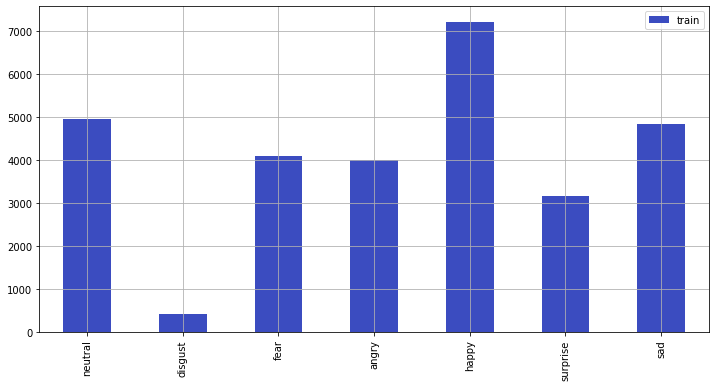

In [ ]:
train_count.transpose().plot(kind='bar',grid = True,colormap='coolwarm',stacked=True,figsize=(12,6))

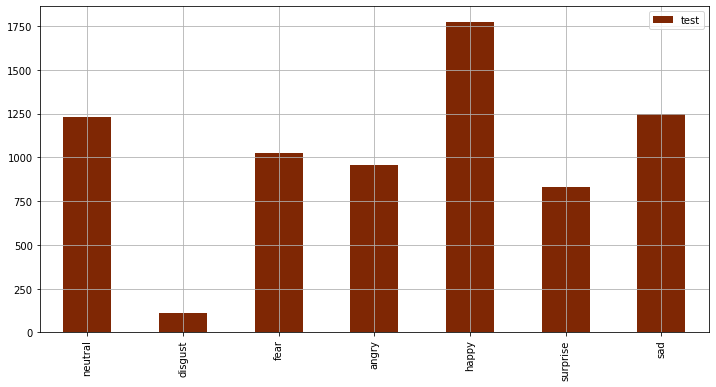

In [ ]:
test_count.transpose().plot(kind='bar',grid = True,colormap='Oranges_r',stacked=True,figsize=(12,6))

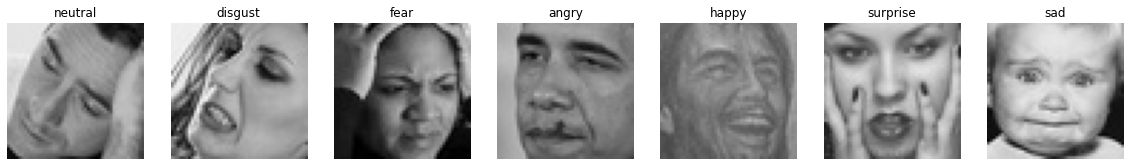

In [ ]:
# Plot and Visulize every emotion of the dataset
plt.figure(figsize=(20,32))
i = 1
for expression in os.listdir(train_addr):
    img = load_img((train_addr +'/'+ expression +'/'+ os.listdir(train_addr +'/'+ expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

In [ ]:
train_data_dir = pathlib.Path(train_addr)
print(train_data_dir)

test_data_dir = pathlib.Path(test_addr)
print(test_data_dir)

/content/train
/content/test


In [ ]:
# Initialize image data generator with rescaling
train_data_gen = ImageDataGenerator(
# You can remove the IageDataGenerator part if your data have been augmented
     rescale=1./255,
     rotation_range=10,
     zoom_range=0.3,
     horizontal_flip=True,
)

validation_data_gen = ImageDataGenerator(
# As above
     rescale=1./255
    )

# Preprocess all test images
train_generator = train_data_gen.flow_from_directory(
        train_addr,
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical',
        shuffle=True)

# Preprocess all train images
validation_generator = validation_data_gen.flow_from_directory(
        test_addr,
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical',
        shuffle=True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
def get_model(input_size, classes=7):
     #Initialising the CNN
    model = tf.keras.models.Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1024, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.5))

    model.add(Dense(classes, activation='softmax',kernel_regularizer=regularizers.l2(0.01)))

    #Compliling the model
    model.compile(optimizer=Adam(lr=0.0001, decay=1e-6),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
fernet = get_model((48,48,1),7)
fernet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
chk_path = 'ckpt_latest'
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)


callbacks = [checkpoint, reduce_lr]

In [ ]:
# Train the neural network/model

steps_per_epoch = 28709 // 64
validation_steps = 7178 // 64


emotion_model_info = fernet.fit(x = train_generator,
                 validation_data=validation_generator,
                 epochs=100,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)



Epoch 1/100
448/448 [==============================] - ETA: 0s - loss: 20.4161 - accuracy: 0.2520
Epoch 1: val_loss improved from inf to 16.25525, saving model to ckpt_latest
448/448 [==============================] - 46s 74ms/step - loss: 20.4161 - accuracy: 0.2520 - val_loss: 16.2553 - val_accuracy: 0.2433 - lr: 1.0000e-04
Epoch 2/100
448/448 [==============================] - ETA: 0s - loss: 11.6818 - accuracy: 0.3155
Epoch 2: val_loss improved from 16.25525 to 8.52437, saving model to ckpt_latest
448/448 [==============================] - 32s 71ms/step - loss: 11.6818 - accuracy: 0.3155 - val_loss: 8.5244 - val_accuracy: 0.3749 - lr: 1.0000e-04
Epoch 3/100
448/448 [==============================] - ETA: 0s - loss: 6.7418 - accuracy: 0.3450
Epoch 3: val_loss improved from 8.52437 to 5.16722, saving model to ckpt_latest
448/448 [==============================] - 31s 70ms/step - loss: 6.7418 - accuracy: 0.3450 - val_loss: 5.1672 - val_accuracy: 0.3903 - lr: 1.0000e-04
Epoch 4/100
448/

# Visulize the Loss & Accuracy

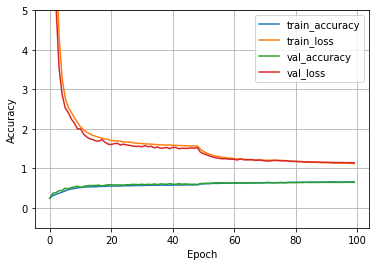

In [ ]:
import matplotlib.pyplot as plt
plt.grid()
plt.plot(emotion_model_info.history['accuracy'], label='train_accuracy')
plt.plot(emotion_model_info.history['loss'], label = 'train_loss')
plt.plot(emotion_model_info.history['val_accuracy'], label='val_accuracy')
plt.plot(emotion_model_info.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([-0.5, 5])
plt.legend(loc='upper right')
plt.show()

In [ ]:
print("The validation accuracy of the model is : {}".format(emotion_model_info.history['val_accuracy'][-1]))

The validation accuracy of the model is : 0.6506696343421936


In [ ]:
fernet.save('facial_emotions_model.h5')

# Model visulization

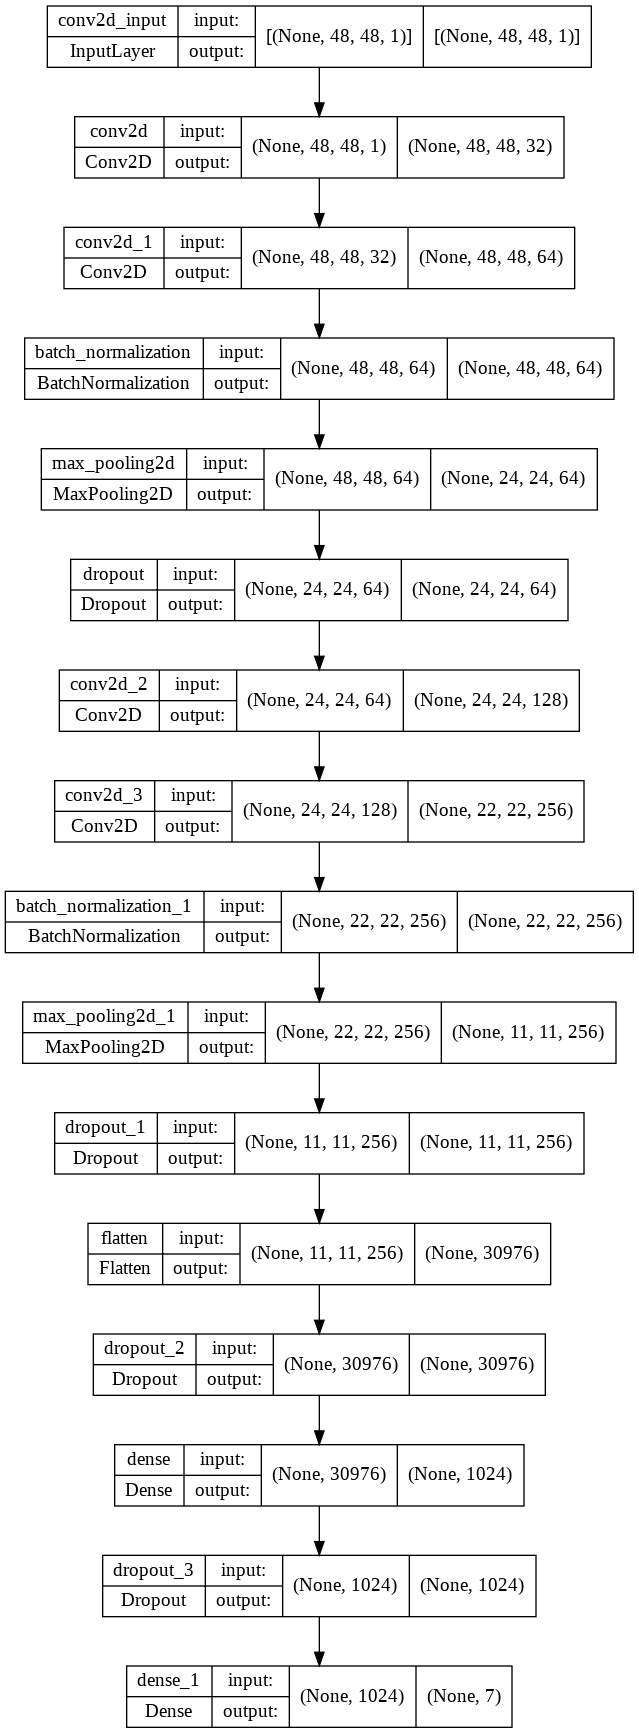

In [ ]:
# Visualize the structure of the network and save the structure as a png file
from keras.utils.vis_utils import plot_model
plot_model(fernet, to_file='emotion_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# fernet.save('/content/gdrive/MyDrive/Colab Notebooks/2022.9.10/weights')
print(emotion_model_info.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


# Confusion Matrix

Confusion Matrix
[[ 537   24  338 1059  832  736  469]
 [  60    8   44  114   80   79   51]
 [ 523   19  394 1148  856  736  421]
 [ 981   45  714 1910 1359 1368  838]
 [ 659   22  474 1378  963  913  556]
 [ 642   25  470 1272  992  864  565]
 [ 424   16  323  825  622  587  374]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.13      0.14      3995
     disgust       0.05      0.02      0.03       436
        fear       0.14      0.10      0.11      4097
       happy       0.25      0.26      0.26      7215
     neutral       0.17      0.19      0.18      4965
         sad       0.16      0.18      0.17      4830
    surprise       0.11      0.12      0.12      3171

    accuracy                           0.18     28709
   macro avg       0.15      0.14      0.14     28709
weighted avg       0.17      0.18      0.17     28709



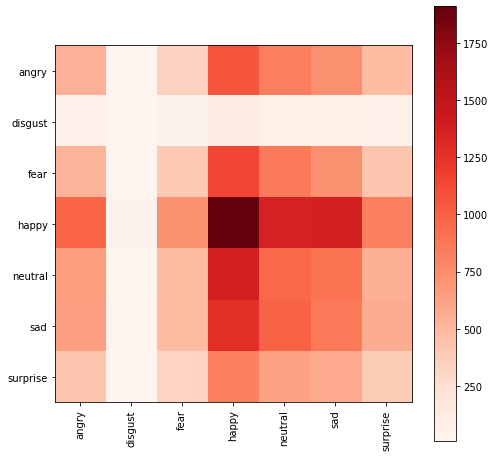

In [ ]:
# Confusion matrix
y_pred = fernet.predict(train_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = validation_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(train_generator.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(train_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest', cmap=plt.cm.Reds)
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

Confusion Matrix
[[132   3  95 246 216 169  97]
 [ 19   1  11  28  28  15   9]
 [169   6  86 250 245 149 119]
 [263   6 142 458 424 265 216]
 [197   8 115 305 272 185 151]
 [211   5 102 312 295 171 151]
 [127   5  73 210 172 134 110]]
Classification Report
              precision    recall  f1-score   support

       angry       0.12      0.14      0.13       958
     disgust       0.03      0.01      0.01       111
        fear       0.14      0.08      0.10      1024
       happy       0.25      0.26      0.26      1774
     neutral       0.16      0.22      0.19      1233
         sad       0.16      0.14      0.15      1247
    surprise       0.13      0.13      0.13       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



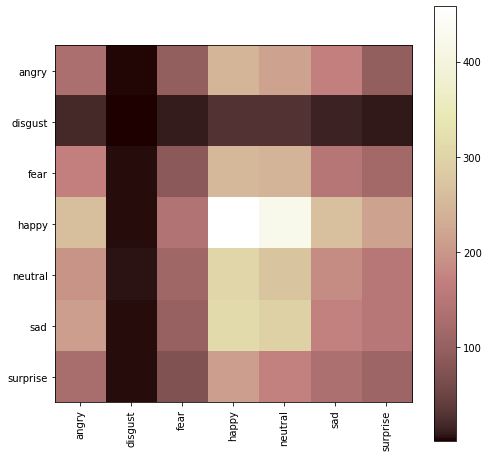

In [ ]:
y_pred = fernet.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = validation_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(validation_generator.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest', cmap=plt.cm.pink)
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

# Feature Map's Function

In [ ]:
def get_feature_maps(model, layer_id, input_image):
    """Returns intermediate output (activation map) from passing an image to the model

    Parameters:
        model (tf.keras.Model): Model to examine
        layer_id (int): Which layer's (from zero) output to return
        input_image (ndarray): The input image
    Returns:
        maps (List[ndarray]): Feature map stack output by the specified layer
    """
    model_ = tf.keras.Model(inputs=[model.input], outputs=[model.layers[layer_id].output])
    return model_.predict(np.expand_dims(input_image, axis=0))[0,:,:,:].transpose((2,0,1))

In [ ]:
# your code here
def test_correct(test_image):

  # obtain feature maps
  feature_maps = get_feature_maps(fernet, 6, test_image)
  c, h, w = feature_maps.shape
  # randomly choose 9 feature maps from 1 to 128
  idxs = np.random.choice(range(0,c), 9, replace=False)

  figure, axis = plt.subplots(3, 3)
  for i in range(3):
    for j in range(3):
      axis[i, j].imshow(feature_maps[idxs[i*3+j]], cmap='gray')
      axis[i, j].set_title("Feature map # {}".format(idxs[i*3+j]+1))

  # Combine all the operations and display
  plt.show()

In [ ]:
!pip install tf-keras-vis tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils import normalize
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from matplotlib import cm

In [ ]:
def plot_visualization(model, X, title, image):
    score = CategoricalScore(list(range(X.shape[0])))

    # Create Saliency visualization object
    saliency = Saliency(model,
                        model_modifier=ReplaceToLinear(),
                        clone=True)

    # Generate saliency map
    saliency_map = saliency(score, X,
                            smooth_samples=20, # The number of calculating gradients iterations
                            smooth_noise=0.20) # noise spread level
    saliency_map = normalize(saliency_map)

    # Create Gradcam visualization object
    gradcam = Gradcam(model,
                     model_modifier=ReplaceToLinear(),
                     clone=True)

    # Generate heatmap by GradCAM
    cam = gradcam(score,
                  X,
                  penultimate_layer=-1)

    # Plot
    f, ax = plt.subplots(nrows=1, ncols=3)

    # original
    ax[0].set_title(title[0], fontsize=16)
    ax[0].imshow(image)
    ax[0].axis('off')

    # saliency map
    ax[1].set_title(title[1], fontsize=16)
    ax[1].imshow(saliency_map[0], cmap='jet')
    ax[1].axis('off')

    # grad-cam
    heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
    ax[2].set_title(title[2], fontsize=16)
    ax[2].imshow(image)
    ax[2].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[2].axis('off')

    plt.tight_layout()
    plt.show()

# Predict

(48, 48, 1)


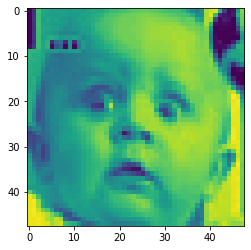

In [ ]:
from tensorflow.keras.preprocessing import image
img_path='/content/test/surprise/PrivateTest_10089743.jpg'
test_image=image.load_img(img_path,target_size=(48,48),color_mode='grayscale')
test_image=image.img_to_array(test_image)
print(test_image.shape)
plt.imshow(np.squeeze(test_image))
plt.show()

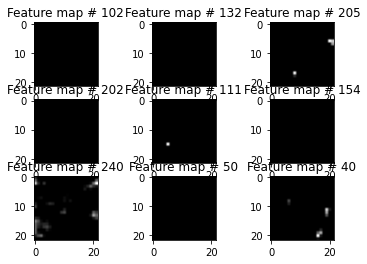

In [ ]:
# feature map
test_correct(test_image)

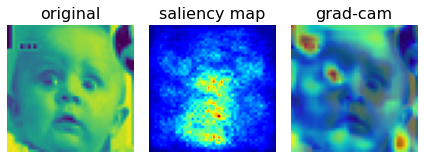

In [ ]:
image_titles = ['original', 'saliency map', 'grad-cam']
test_sample = np.expand_dims(test_image, axis=0)
x = test_sample
plot_visualization(fernet, x, image_titles, np.squeeze(test_image))

In [ ]:
test_image=test_image.reshape(1,48,48,1)
classes=['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']
result=fernet.predict(test_image)
print(result[0])
y_pred=np.argmax(result[0])
print('The person facial emotion is:',classes[y_pred])

[0. 0. 0. 1. 0. 0. 0.]
The person facial emotion is: Happy


(48, 48, 1)


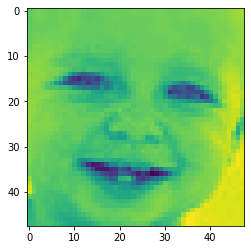

In [ ]:
img_path='/content/test/happy/PrivateTest_1140198.jpg'
test_image=image.load_img(img_path,target_size=(48,48),color_mode='grayscale')
test_image=image.img_to_array(test_image)
print(test_image.shape)
plt.imshow(np.squeeze(test_image))
plt.show()

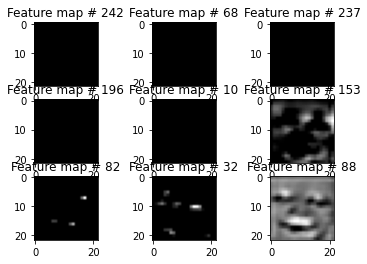

In [ ]:
# Get feature map
test_correct(test_image)

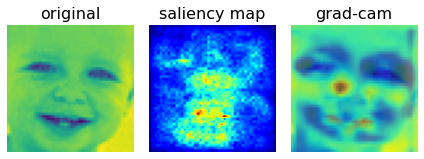

In [ ]:
image_titles = ['original', 'saliency map', 'grad-cam']
test_sample = np.expand_dims(test_image, axis=0)
x = test_sample
plot_visualization(fernet, x, image_titles, np.squeeze(test_image))

In [ ]:
test_image=test_image.reshape(1,48,48,1)
classes=['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']
result=fernet.predict(test_image)
print(result[0])
y_pred=np.argmax(result[0])
print('The person facial emotion is:',classes[y_pred])

[0. 0. 0. 1. 0. 0. 0.]
The person facial emotion is: Happy
